In [73]:
%load_ext autoreload
%autoreload 2

import re
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
import spacy
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Load data:
file_path = '../data/raw/complaints-2021-05-14_08_16_.json'
with open(file_path, 'r') as f:
    data = json.load(f) 
    df = pd.json_normalize(data)

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [10]:
# Rename column names:
df.columns = [
    'index', 'type', 'id', 'score', 'tags', 'zip_code',
    'complaint_id', 'issue', 'date_received', 'state', 
    'consumer_disputed', 'product', 'company_response', 
    'company', 'submitted_via', 'date_sent_to_company', 
    'company_public_response', 'sub_product', 'timely',
    'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'
]

In [11]:
# Check percentage of missing value
df.isna().sum() / len(df) * 100

index                         0.000000
type                          0.000000
id                            0.000000
score                         0.000000
tags                         86.081493
zip_code                      8.628197
complaint_id                  0.000000
issue                         0.000000
date_received                 0.000000
state                         2.542362
consumer_disputed             0.000000
product                       0.000000
company_response              0.000000
company                       0.000000
submitted_via                 0.000000
date_sent_to_company          0.000000
company_public_response      99.994892
sub_product                  13.498397
timely                        0.000000
complaint_what_happened       0.000000
sub_issue                    59.117899
consumer_consent_provided     1.287143
dtype: float64

In [12]:
# Handle missing values:
df['complaint_what_happened'] = df['complaint_what_happened'].replace('', np.nan)
print(f'DataFrame shape: {df.shape}')

# Drop based on empty values of customer complaints:
df = df.dropna(subset=['complaint_what_happened'])
df = df[['complaint_what_happened']].reset_index(drop=True)
print(f'DataFrame shape (after dropping NaN values): {df.shape}')

DataFrame shape: (78313, 22)
DataFrame shape (after dropping NaN values): (21072, 1)


In [6]:
# Functions
def normalize_text(text: str) -> str:
    """Normalize a text.
    
    Args:
        text (str): text.
    Returns:
        str: normalized text.
    """
    return text.lower().strip()

def remove_punctuations(text) -> str:
    """Remove punctuations from a text.
    
    Args:
        text (str): text.
    Returns:
        str: text with removed punctuations.
    """
    return re.sub(r'[^\w\s]', '', text)

def remove_word_brackets(text) -> str:
    """Remove words in brackets from a text.
    
    Args:
        text (str): text.
    Returns:
        str: text with removed words in brackets.
    """
    return re.sub(r'\[.*?\]', '', text)

def remove_word_numbers(text) -> str:
    """Remove punctuations from a text.
    
    Args:
        text (str): text.
    Returns:
        str: text with removed punctuations.
    """
    return re.sub(r'\b\w*\d\w*\b', '', text)

def remove_confidential_information(text) -> str:
    """Remove confidential information from a text.
    
    Args:
        text (str): text.
    Returns:
        str: text with removed confidential information.
    """
    return  re.sub(r'\bx{1,}\b', '', text)

def remove_extra_spaces(text) -> str:
    """Remove extra spaces or new lines from a text.
    
    Args:
        text (str): text.
    Returns:
        str: text with removed extra spaces or new lines.
    """
    return re.sub(r'\s+', ' ', text)

def clean_text(text: str) -> str:
    """Clean text.
    
    Args:
        text (str): text.
    Returns:
        str: cleaned text.
    """
    text = normalize_text(text)
    text = remove_punctuations(text)
    text = remove_word_brackets(text)
    text = remove_word_numbers(text)
    text = remove_confidential_information(text)
    text = remove_extra_spaces(text)
    return text

# Text cleaning
df['cleaned_complaint_what_happened'] = df['complaint_what_happened'].apply(clean_text)

In [11]:
# Set display options to prevent truncation
pd.set_option('display.max_colwidth', None)  # Set None for no limit
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping to multiple lines

df.head()

,complaint_what_happened,cleaned_complaint_what_happened
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen an

In [37]:
# # Run this this before the next cell
# !python -m spacy download en_core_web_sm

In [18]:
nlp = spacy.load('en_core_web_sm')

def lemma_texts(text):
    # Initialize list to contain lemmas
    lemmas = []
    
    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(text)
    for token in document:
        if not token.is_stop:
            lemmas.append(token.lemma_)

    # Return string converted form of the list of lemmas
    return " ".join(lemmas)

# Apply lemmatization
start = time.perf_counter()
df['lemmatized_complaint_what_happened'] = df['cleaned_complaint_what_happened'].apply(lemma_texts)
stop = time.perf_counter()
print(f"Lemmatization process took around {stop - start: .2f} seconds")

Lemmatization process took around  774.31 seconds


In [20]:
# Set display options to prevent truncation
pd.set_option('display.max_colwidth', None)  # Set None for no limit
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping to multiple lines

df.head()

,complaint_what_happened,cleaned_complaint_what_happened,lemmatized_complaint_what_happened
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning appreciate help stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt right know information consumer chase account thank advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,upgrade card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account change anniversary date consent recording agent mislead
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit R

In [24]:
# Extract nouns which leads us to the topic
def extract_singular_nouns(text):
    blob = TextBlob(text)
    return ' '.join([word for word, tag in blob.tags if tag=='NN'])

# Applying the function to create a new column containing only singular nouns 
df["complaint_lemmatized_nouns"] =  df['lemmatized_complaint_what_happened'].apply(extract_singular_nouns)

# View the dataframe
df.head()

,complaint_what_happened,cleaned_complaint_what_happened,lemmatized_complaint_what_happened,complaint_lemmatized_nouns
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning appreciate help stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt right know information consumer chase account thank advance help,morning appreciate help chase bank cardmember service chase debt verification statement bank debt mail month attempt debt right information consumer chase account advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,upgrade card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account change anniversary date consent recording agent mislead,card tell agent date change information order upgrade account change date consent agent mislead
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,card report application submit identity consent service credit verify identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the applicat

In [25]:
# Save data
df.to_csv("../data/processed/preprocessed_texts.csv", index=False)

# Data Visualization

In [15]:
# Load data
df = pd.read_csv("../data/processed/preprocessed_texts.csv")
df = df.dropna()
df.head()

,complaint_what_happened,cleaned_complaint_what_happened,lemmatized_complaint_what_happened,complaint_lemmatized_nouns
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning appreciate help stop chase bank c...,morning appreciate help chase bank cardmember ...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,upgrade card tell agent upgrade anniversary da...,card tell agent date change information order ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application submit identity consen...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,try book ticket come offer apply ticket apply ...,book ticket come apply ticket card information...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...


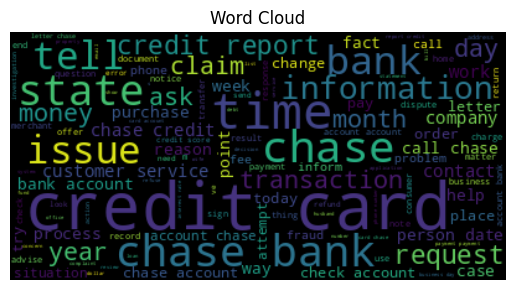

In [16]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(str(df["complaint_lemmatized_nouns"].tolist()))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud")
plt.axis("off")
plt.show()

In [75]:
df['complaint_lemmatized_nouns'].values.astype('U')

array(['morning appreciate help chase bank cardmember service chase debt verification statement bank debt mail month attempt debt right information consumer chase account advance help',
       'card tell agent date change information order upgrade account change date consent agent mislead',
       'card report application submit identity consent service credit verify identity applicant',
       ...,
       'pay risk consumer chase bank year trust tell deal merchant merchant refuse answer inquiry shut communication look face brand medium consent perform research phone number information pi merchant account title holder perpetuate cycle fraud bank report report recourse matter place issue chase verbiage point position chase banking service entitlement customer service protection protocol chase place consumer risk service flag concern chase risk app stand plan report correspond authority identity misuse inform urge neighbor work television news network risk understand fraud banking mogul 

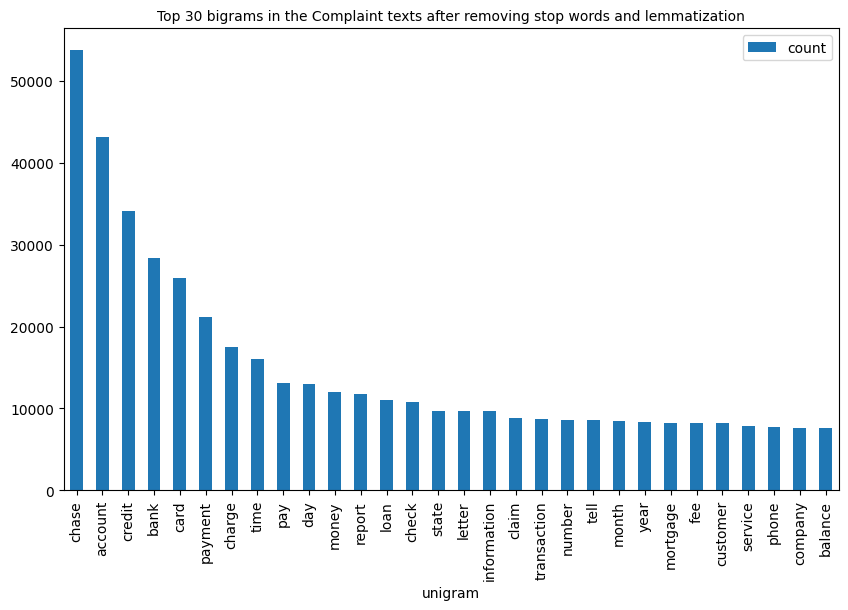

In [82]:
def get_top_unigram(texts: list, n: int=30) -> list:
    """Return the top unigrams inside all texts.

    Args:
        texts (list): list of all texts
        n (int, optional): top n items to be returned. Defaults to 30.

    Returns:
        list: list of top unigrams
    """
    vector = CountVectorizer(stop_words='english').fit(texts)
    bag_of_words = vector.transform(texts)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]


# Create DataFrame of top unigrams
top_common_words = get_top_unigram(df['complaint_lemmatized_nouns'].tolist())
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])


# Plot the top 30 unigrams
df_unigram.plot(kind='bar', x='unigram', y='count', figsize=(10,6))
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint texts after removing stop words and lemmatization", fontsize=10)
plt.show()

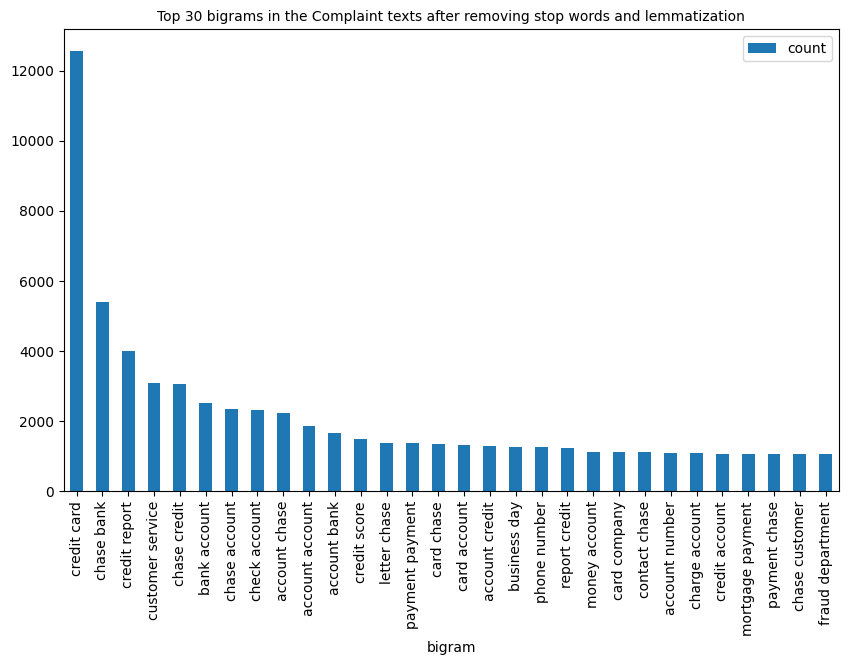

In [85]:
def get_top_bigram(texts: list, n: int=30) -> list:
    """Return the top bigrams inside all texts.

    Args:
        texts (list): list of all texts
        n (int, optional): top n items to be returned. Defaults to 30.

    Returns:
        list: list of top bigrams
    """
    vector = CountVectorizer(ngram_range=(2,2), stop_words='english').fit(texts)
    bag_of_words = vector.transform(texts)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

# Create DataFrame of top bigrams
top_common_words = get_top_bigram(df['complaint_lemmatized_nouns'].tolist())
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])


# Plot the top 30 bigrams
df_bigram.plot(kind='bar', x='bigram', y='count', figsize=(10,6))
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint texts after removing stop words and lemmatization", fontsize=10)
plt.show()

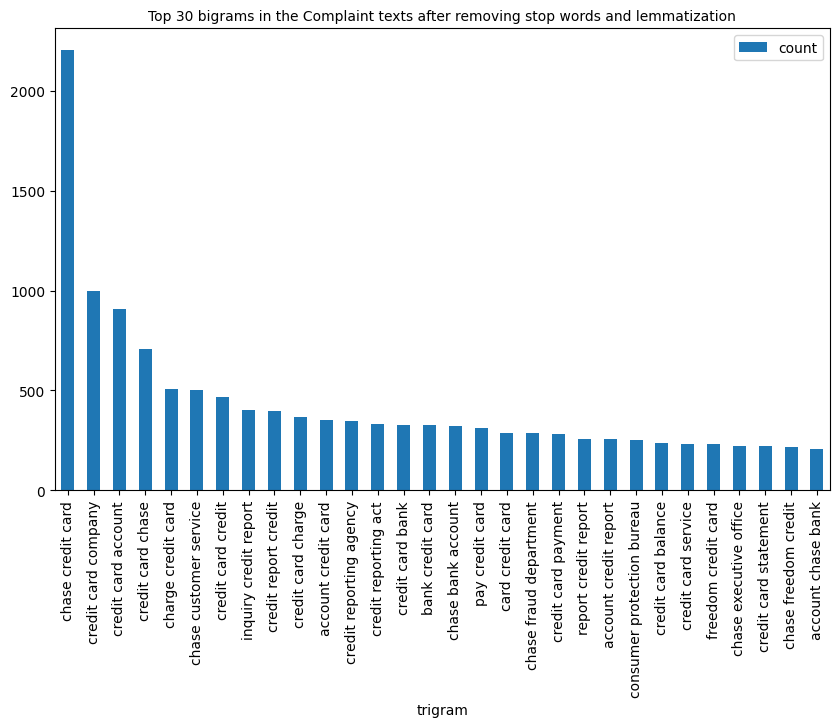

In [87]:
def get_top_trigram(text, n=30):
    """Return the top trigrams inside all texts.

    Args:
        texts (list): list of all texts
        n (int, optional): top n items to be returned. Defaults to 30.

    Returns:
        list: list of top trigrams
    """
    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

# Create DataFrame of top trigrams
top_common_words = get_top_trigram(df['complaint_lemmatized_nouns'].tolist())
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])


# Plot the top 30 trigrams
df_trigram.plot(kind='bar', x='trigram', y='count', figsize=(10,6))
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint texts after removing stop words and lemmatization", fontsize=10)
plt.show()

# Feature Extraction

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Write your code here to initialise the TfidfVectorizer 

tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

dtm = tfidf.fit_transform(df['complaint_lemmatized_nouns'])


In [70]:
dtm

<21067x7277 sparse matrix of type '<class 'numpy.float64'>'
	with 710752 stored elements in Compressed Sparse Row format>

# Topic Modelling using NMF

In [77]:
from sklearn.decomposition import NMF

In [79]:
#Coherence model to find best number of topics
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['complaint_lemmatized_nouns']
data_set = [x.split() for x in texts]

# Creating a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(data_set)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Creating the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in data_set]

# Create a list of the topic numbers we want to try
topic_num = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_num:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=40
    )
    
    # Run the coherence model to get the score
    coherence_model = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(coherence_model.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_num, coherence_scores))
best_topics_num = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_topics_num)

KeyboardInterrupt: 